# TSP LP with Lazy constraints by Pulp

Pulp: https://github.com/coin-or/pulp  
reference: https://techblog.aimms.com/2015/05/26/solving-a-tsp-using-lazy-constraints/

In [195]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pulp import *
seed = 42
np.random.seed(seed=seed)

In [196]:
# Generate parameters
def gen_param(num):
    path = list(range(num))
    X = np.random.random(num)
    Y = np.random.random(num)
    XY = X + Y * 1j
    return num, path, X, Y, XY

In [197]:
# Plot path, edges, subtours
def plot_path(path, edges=False, size=6):
    plt.figure(figsize=(size, size))
    cmap = plt.get_cmap("tab10")
    plt.axis([0,1,0,1], 'equal')
    plt.plot(X[path], Y[path], alpha=0.0)
    plt.scatter(X[0], Y[0], s=80, c='r', marker='o')
    if path:
        for i in range(len(path)-1):
            plt.arrow(X[path[i]], Y[path[i]], 
                      X[path[i+1]]-X[path[i]], Y[path[i+1]]-Y[path[i]], 
                      head_width=0.02, head_length=0.02, length_includes_head=True, 
                      fc=cmap(0), ec=cmap(0))
    if edges:
        for e in edges:
            plt.plot([X[e[0]], X[e[1]]], [Y[e[0]], Y[e[1]]])
    
    for i in range(num):
        plt.text(X[i], Y[i]+0.01, s=i, fontsize=10, color='gray')

Initial Plot: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


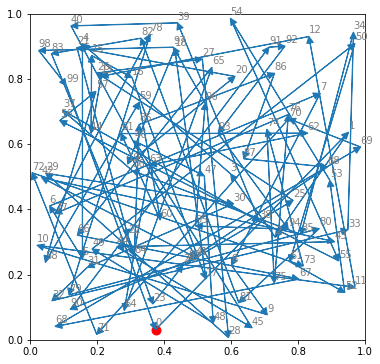

In [198]:
# Generate parameters and Plot initial path
num, path, X, Y, XY = gen_param(100) # the number of nodes
plot_path(path + [0])
print('Initial Plot:', path)

## LP by Pulp

In [199]:
prob = LpProblem(name='TSP_LP', sense=LpMinimize)

# node i to node j: distance between i and j
dist = dict({(i, j): (abs(XY[i] - XY[j])) for i in range(num) for j in range(num) if i != j})

#  1: the tour includes the edge from i to j, 0: if not included
x = LpVariable.dicts('x', dist, 0, 1, LpBinary)

# the objective to be minimumized
prob += lpSum([dist[(i,j)] * x[(i,j)] for i, j in dist])

# Base constraints: a route from i to j should be only one, same to j to i
for i in path:
    prob += lpSum([x[(i, j)] for j in path if i != j]) == 1
    
for j in path:
    prob += lpSum([x[(i, j)] for i in path if i != j]) == 1

In [200]:
# Optional constraints (if needed):
# Diagonal asymmetry constraints: to avoid such as (0, 1) and (1, 0) on the same tour
for i in path:
    for j in path:
        if i < j:
            prob += lpSum([x[(i, j)] + x[(j, i)]]) <= 1

In [201]:
# Minimize the problem
%time prob.solve()
print(LpStatus[prob.status]) 

CPU times: user 229 ms, sys: 9.1 ms, total: 238 ms
Wall time: 1.34 s
Optimal


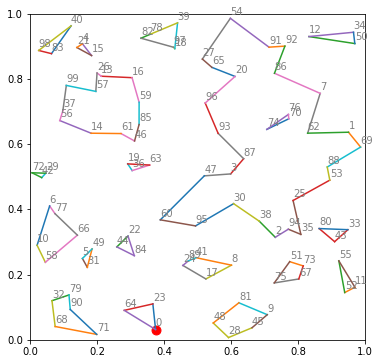

In [202]:
# Edges in the progress, there might be some subtours
E = [(i, j) for (i, j) in x if x[(i, j)].varValue == 1]
plot_path(False, E)

## Lazy constraints:

In [203]:
ED = []
while True:
    # Find edges as x(i, j) = 1
    E = [(i, j) for (i, j) in x if x[(i, j)].varValue == 1]
    ED.append(E)
    # Connect the edges to form subtours
    ST = []
    for n in path:
        if n not in sum(ST, []):
            subtour = [n]
            for _ in path:
                for (i, j) in E:
                    if subtour[-1] == i and j not in subtour:
                        subtour.append(j)
                    elif j == subtour[-1] and i not in subtour:
                        subtour.append(i)
            subtour.append(subtour[0])
            ST.append(subtour)

    print('Subtour :', ST)
    if len(ST) == 1:
        print('\nOPT TOUR:', ST[0])
        print('SOLVED')
        break
        
    # Lazy constraints: 
    # Either of (i, j) in the subtour has to connect to a node in the other subtour,
    # hence 'i' stays in the subtour and 'j' has to be changed to one in the other subtour, and vice versa for (j, i)
    for st in ST:
        nots = [j for j in path if j not in st]
        prob += lpSum(x[(i, j)] for i in st[:-1] for j in nots if (i, j) in x) >= 1
        prob += lpSum(x[(j, i)] for i in st[:-1] for j in nots if (i, j) in x) >= 1
    prob.solve()

T = ST[0]
# 150 nodes: 3m 37s
# 200 nodes: 1m 4.53s

Subtour : [[0, 23, 64, 0], [1, 69, 88, 53, 25, 35, 94, 2, 38, 30, 95, 60, 47, 3, 87, 93, 96, 20, 65, 27, 54, 91, 92, 86, 7, 62, 1], [4, 15, 21, 4], [5, 31, 49, 5], [6, 77, 66, 58, 10, 6], [8, 17, 24, 89, 41, 8], [9, 81, 48, 28, 45, 9], [11, 52, 55, 11], [12, 50, 34, 12], [13, 16, 59, 85, 46, 61, 14, 56, 37, 99, 57, 26, 13], [18, 97, 82, 78, 39, 18], [19, 36, 63, 19], [22, 44, 84, 22], [29, 42, 72, 29], [32, 79, 90, 71, 68, 32], [33, 43, 80, 33], [40, 83, 98, 40], [51, 73, 67, 75, 51], [70, 74, 76, 70]]
Subtour : [[0, 71, 64, 23, 0], [1, 7, 50, 34, 12, 92, 86, 91, 54, 39, 78, 82, 97, 18, 27, 65, 20, 96, 93, 87, 3, 47, 30, 95, 41, 89, 24, 17, 8, 81, 48, 28, 45, 9, 75, 51, 73, 67, 52, 11, 55, 43, 33, 80, 35, 94, 2, 38, 25, 53, 88, 69, 1], [4, 21, 40, 98, 83, 99, 37, 56, 14, 61, 85, 59, 16, 57, 13, 26, 15, 4], [5, 31, 58, 10, 66, 49, 5], [6, 77, 29, 72, 42, 6], [19, 46, 63, 36, 19], [22, 44, 84, 60, 22], [32, 68, 90, 79, 32], [62, 70, 76, 74, 62]]
Subtour : [[0, 23, 84, 44, 22, 60, 95, 41,

Optimal Tour : [0, 23, 84, 44, 22, 60, 95, 41, 89, 24, 17, 8, 81, 48, 28, 45, 9, 75, 51, 73, 67, 52, 11, 55, 43, 33, 80, 35, 94, 2, 38, 25, 53, 88, 69, 1, 62, 74, 70, 76, 7, 50, 34, 12, 92, 86, 91, 54, 39, 78, 82, 97, 18, 27, 65, 20, 96, 93, 87, 3, 30, 47, 63, 36, 19, 46, 61, 85, 59, 16, 57, 13, 26, 15, 4, 21, 40, 98, 83, 99, 37, 56, 14, 29, 72, 42, 6, 77, 10, 58, 66, 49, 5, 31, 79, 32, 90, 68, 71, 64, 0]
Tour Distance: 7.936534839976931


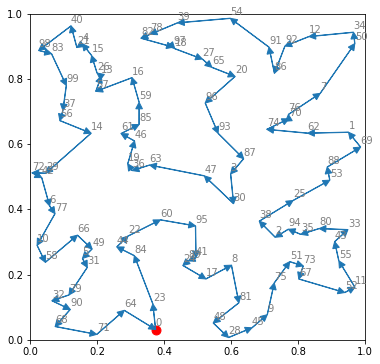

In [204]:
# Optimal Tour outputs
tour_dist = sum([dist[(T[i - 1], T[i])] for i in range(1, len(T))])
print('Optimal Tour :', T)
print('Tour Distance:', tour_dist)
plot_path(T)

## Animation: Lazy subtour elimination process

In [205]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(6,6))
cmap = plt.get_cmap("tab10")
plt.axis([0,1,0,1], 'equal')

ims = []
for ed in ED:
    P0 = plt.plot(X[path], Y[path], alpha=0.0)
    P1 = plt.scatter(X[0], Y[0], s=80, color='r', marker='o')
    P2 = plt.scatter(X[1:], Y[1:], s=40, color=cmap(0), marker='o')
    ii = [e[0] for e in ed]
    jj = [e[1] for e in ed]
    P3 = plt.plot([X[ii], X[jj]], [Y[ii], Y[jj]], color=cmap(0))
    P4 = [plt.text(X[i], Y[i]+0.02, s=i, fontsize=10, color='gray') for i in range(num)]
    ims.append(P0 + [P1] + [P2] + P3 + P4)
    
ani = animation.ArtistAnimation(fig, ims, interval=800)
#ani.save("lp_pulp_anim_" + str(num) + ".gif", writer = "imagemagick")
plt.close()
print('Optimal Tour :', T)
HTML(ani.to_jshtml())

Optimal Tour : [0, 23, 84, 44, 22, 60, 95, 41, 89, 24, 17, 8, 81, 48, 28, 45, 9, 75, 51, 73, 67, 52, 11, 55, 43, 33, 80, 35, 94, 2, 38, 25, 53, 88, 69, 1, 62, 74, 70, 76, 7, 50, 34, 12, 92, 86, 91, 54, 39, 78, 82, 97, 18, 27, 65, 20, 96, 93, 87, 3, 30, 47, 63, 36, 19, 46, 61, 85, 59, 16, 57, 13, 26, 15, 4, 21, 40, 98, 83, 99, 37, 56, 14, 29, 72, 42, 6, 77, 10, 58, 66, 49, 5, 31, 79, 32, 90, 68, 71, 64, 0]


## Comparison with TSP Solver Pyconcorde  
pyconcorde: https://github.com/jvkersch/pyconcorde

TSP Tour: [0, 23, 84, 44, 22, 60, 95, 41, 89, 24, 17, 8, 81, 48, 28, 45, 9, 75, 51, 73, 67, 52, 11, 55, 43, 33, 80, 35, 94, 2, 38, 25, 53, 88, 69, 1, 62, 74, 70, 76, 7, 50, 34, 12, 92, 86, 91, 54, 39, 78, 82, 97, 18, 27, 65, 20, 96, 93, 87, 3, 30, 47, 63, 36, 19, 46, 61, 85, 59, 16, 57, 13, 26, 15, 4, 21, 40, 98, 83, 99, 37, 56, 14, 29, 72, 42, 6, 77, 10, 58, 66, 49, 5, 31, 79, 32, 90, 68, 71, 64, 0]
Total Distance: 7.936534839976931


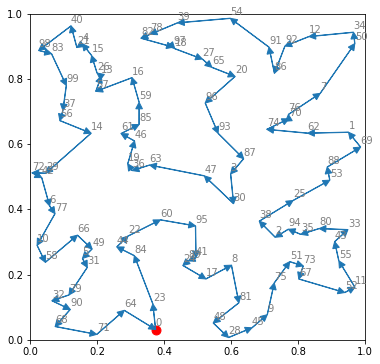

In [206]:
from concorde.tsp import TSPSolver

#num, path, X, Y, XY = gen_param(100)
solver = TSPSolver.from_data(X[path]*10**6, Y[path]*10**6, norm='EUC_2D')
solution = solver.solve()
#print(solution.found_tour)
tsp_tour = list(solution.tour) + [0]
plot_path(tsp_tour)
print('TSP Tour:', tsp_tour)
tsp_dist = sum([dist[(tsp_tour[i - 1], tsp_tour[i])] for i in range(1, len(tsp_tour))])
print('Total Distance:', tsp_dist)

In [207]:
# comparison score: Lazy subtour elimination constraints / Pyconcorde
print('Lazy SEC  :', tour_dist)
print('Pyconcorde:', tsp_dist)
print('Score rate:', tour_dist / tsp_dist)

Lazy SEC  : 7.936534839976931
Pyconcorde: 7.936534839976931
Score rate: 1.0


In [217]:
f = open("lazy_const.txt", "w")
f.write(ani.to_jshtml())
f.close() 